In [27]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [28]:
# Load the images and labels into a dataframe
data = []
labels = []
image_size = 224
for folder in ['emergency', 'non-emergency']:
    label = 1 if folder == 'emergency' else 0 # assign 1 for emergency and 0 for non-emergency
    for file in glob.glob(f'{folder}/*.jpg'): # iterate over the image files
        image = cv2.imread(file) # read the image
        image = cv2.resize(image, (image_size, image_size)) # resize the image
        data.append(image) # append the image to the data list
        labels.append(label) # append the label to the labels list
data = np.array(data) / 255.0 # convert the data to a numpy array and normalize it
labels = np.array(labels) # convert the labels to a numpy array
df = pd.DataFrame({'data': list(data), 'labels': labels}) # create a dataframe from the data and labels
df.head() # show the first five rows of the dataframe

,data,labels
0,"[[[0.5529411764705883, 0.5254901960784314, 0.4...",1
1,"[[[0.09411764705882353, 0.11372549019607843, 0...",1
2,"[[[0.7607843137254902, 0.7019607843137254, 0.6...",1
3,"[[[0.2196078431372549, 0.25882352941176473, 0....",1
4,"[[[0.16470588235294117, 0.3333333333333333, 0....",1


In [29]:
# Split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['data'].tolist(), df['labels'].tolist(), test_size=0.2, shuffle=True, random_state=42) # split the data and labels into 80% training and 20% testing sets
X_train = np.array(X_train) # convert the training data to a numpy array
X_test = np.array(X_test) # convert the testing data to a numpy array
y_train = np.array(y_train) # convert the training labels to a numpy array
y_test = np.array(y_test) # convert the testing labels to a numpy array
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # print the shapes of the arrays

(1316, 224, 224, 3) (330, 224, 224, 3) (1316,) (330,)


In [30]:
# Define the model architecture
base_model = tf.keras.applications.MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet') # load the pre-trained MobileNetV2 model without the top layer and with the imagenet weights
base_model.trainable = False # freeze the base model layers
model = tf.keras.models.Sequential() # create a sequential model
model.add(base_model) # add the base model as the first layer
model.add(tf.keras.layers.GlobalAveragePooling2D()) # add a global average pooling layer to reduce the dimensions
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # add a dense layer with one unit and sigmoid activation for binary classification
model.add(tf.keras.layers.Dropout(0.2)) # add a dropout layer to prevent overfitting
model.summary() # print the model summary

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
 dropout_3 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [31]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()]) # use binary crossentropy and binary accuracy for binary classification

In [33]:
# Train the model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', save_best_only=True, mode='max') # use val_binary_accuracy as the monitor
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, earlystop])

Epoch 1/50
42/42 [==============================] - 22s 528ms/step - loss: 1.2928 - binary_accuracy: 0.9027 - val_loss: 0.1773 - val_binary_accuracy: 0.9303
Epoch 2/50
42/42 [==============================] - 20s 475ms/step - loss: 1.4404 - binary_accuracy: 0.8936 - val_loss: 0.1682 - val_binary_accuracy: 0.9364
Epoch 3/50
42/42 [==============================] - 20s 471ms/step - loss: 1.4136 - binary_accuracy: 0.8967 - val_loss: 0.1666 - val_binary_accuracy: 0.9394
Epoch 4/50
42/42 [==============================] - 19s 456ms/step - loss: 1.3923 - binary_accuracy: 0.8951 - val_loss: 0.1873 - val_binary_accuracy: 0.9303
Epoch 5/50
42/42 [==============================] - 26s 633ms/step - loss: 1.2693 - binary_accuracy: 0.9073 - val_loss: 0.1835 - val_binary_accuracy: 0.9303
Epoch 6/50
42/42 [==============================] - 20s 471ms/step - loss: 1.3735 - binary_accuracy: 0.9027 - val_loss: 0.1739 - val_binary_accuracy: 0.9333
Epoch 7/50
42/42 [==============================] - 21s 50

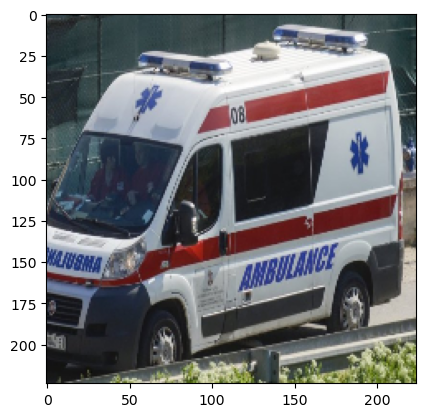

In [25]:
# Preprocess your images and videos
img = cv2.imread('ambulance.jpg')
img = cv2.resize(img, (224, 224))
# img = cv2.convertScaleAbs(img) # this is not needed
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [26]:
#Video Demo
cap = cv2.VideoCapture('Emergency.mp4')
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise IOError("Cannot open video")

    
font_scale = 3
font = cv2.FONT_HERSHEY_PLAIN

while True:
    ret,frame = cap.read()
    
    # ClassIndex, confidece, bbox = model.detect(frame,confThreshold=0.55) # this is not a valid method for tf.keras models
    # Use model.predict instead and apply a threshold to get the binary labels
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.expand_dims(frame, axis=0) # add a batch dimension
    pred = model.predict(frame) # get the prediction
    label = 1 if pred > 0.5 else 0 # apply a threshold
    bbox = (0, 0, 224, 224) # use the whole frame as the bounding box
    
    print(label)
    # if (len(ClassIndex)!=0):
    #     for ClassInd, conf, boxes in zip(ClassIndex.flatten(), confidece.flatten(), bbox):
    #         if (ClassInd<=80):
    #             cv2.rectangle(frame, boxes,(255, 0, 0), 2 )
    #             cv2.putText(frame,classLabels[ClassInd-1],(boxes[0]+10,boxes[1]+40), font, fontScale=font_scale,color=(0, 255, 0), thickness=3 )
    # Use the label and the bbox to draw the rectangle and the text
    cv2.rectangle(frame, bbox, (255, 0, 0), 2)
    cv2.putText(frame, classLabels[label], (bbox[0]+10, bbox[1]+40), font, fontScale=font_scale, color=(0, 255, 0), thickness=3)
                
    cv2.imshow('Kizito Object Detection', frame)
                
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 3s 3s/step
0


NameError: name 'classLabels' is not defined